File Name: VAE

Description: This files contains the code for the varitional autoencoder. After the BVAE is constructed then it then goes on to train it with gin data set, then using a TSNE scatterplot to visualise the latent space. New samples are then generated and saved for later assessment.

In [1]:
import tensorflow as tf
import keras 
from keras import layers, Model
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import copy
from keras.layers import LeakyReLU
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import json
import math
import pickle

2025-09-06 18:19:17.171627: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 18:19:17.242640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-06 18:19:17.242687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-06 18:19:17.244166: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-06 18:19:17.254700: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-06 18:19:17.255901: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
df = pd.read_csv('../../data/unlabelled_data.csv')
df.drop(columns=['Juniper'], inplace=True)

botanicals = df.iloc[:,26:278]

In [3]:
botanicals

,Rosewater,Honey,Lemon Myrtle,Herb-Robert,Camomile,Rose,Jasmine,Passion Flower,Acacia Flower,Elderflower,...,Tangerine,Black Lemon,Buddha's Hand,Calamansi,Jaffa Cakes,Treacle,Bee Pollen,Collagen,Angostura Bitters,Balsamic Vinegar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
548,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
549,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
550,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
@keras.saving.register_keras_serializable()
class Sampling(layers.Layer):
    """Uses (mean, log_var) to sample z, the vector encoding a digit."""

    
    def call(self, inputs):
        mean, log_var = inputs
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return mean + tf.exp(0.5*log_var) * epsilon

In [5]:
#latent_dim size
latent_dim = 52

#get encoder layers
encoder_inputs = keras.Input(shape=(botanicals.columns.__len__(),))
x = layers.Dense(350, activation="relu")(encoder_inputs)

#output layers for mean and log_var
mean = layers.Dense(latent_dim, name="mean")(x)
log_var = layers.Dense(latent_dim, name="log_var")(x)

#get reparamsetrised vector for backpropagation
z = Sampling()([mean, log_var])

#create the encoder model
encoder = keras.Model(encoder_inputs, [mean, log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 252)]                0         []                            
                                                                                                  
 dense (Dense)               (None, 350)                  88550     ['input_1[0][0]']             
                                                                                                  
 mean (Dense)                (None, 52)                   18252     ['dense[0][0]']               
                                                                                                  
 log_var (Dense)             (None, 52)                   18252     ['dense[0][0]']               
                                                                                            

In [6]:
#input from the latent space
latent_inputs = keras.Input(shape=(latent_dim,))

#rebuild the data
x = layers.Dense(350, activation="relu")(latent_inputs)
x = layers.Dropout(0.2)(x)
#uses sigmoid as botanicals are binary
decoder_outputs = layers.Dense(botanicals.columns.__len__(), activation="sigmoid")(x)

#creating the decoder model
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 52)]              0         
                                                                 
 dense_1 (Dense)             (None, 350)               18550     
                                                                 
 dropout (Dropout)           (None, 350)               0         
                                                                 
 dense_2 (Dense)             (None, 252)               88452     
                                                                 
Total params: 107002 (417.98 KB)
Trainable params: 107002 (417.98 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        # Initialize the encoder and decoder
        self.encoder = encoder
        self.decoder = decoder
        # Initialize metrics to show loss during training
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        try:
            self.serialize_ko = keras.saving.serialize_keras_object
            self.deserialize_ko = keras.saving.deserialize_keras_object
        except AttributeError:
            self.serialize_ko = keras.utils.serialize_keras_object
            self.deserialize_ko = keras.utils.deserialize_keras_object
        
    def save_models(self):
        # Save the model to the specified filepath
        self.encoder.save("../../models/trad_arch_encoder.keras")
        self.decoder.save("../../models/trad_arch_decoder.keras")
        


    @property
    def metrics(self):
        # Return the list of metrics to track during training
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    
    def get_config(self):
        base = super().get_config()
        return {
            **base,
            "encoder": self.serialize_ko(self.encoder),
            "decoder": self.serialize_ko(self.decoder),
        } 
        
        
    def train_step(self, data):
        
        with tf.GradientTape() as tape:
            #get the mean, log_var and  from the encoder
            mean,log_var, z = self.encoder(data)
            #! add another layer here that adds the one hot encoded label of the botanicals to the decoder 
            #!info = labeler(data[1] , z)
            
            # print(mean.shape)
            # print(log_var.shape)
            reconstruction = self.decoder(z)
            #calculate the reconstruction loss with binary crossentropy
            
            reconstruction_loss = keras.losses.binary_crossentropy(data, reconstruction)
            # tf.reduce_mean(
            #     tf.reduce_sum(
            #         ,
            #     )
            # )
            
            #calculate the KL divergence loss
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(kl_loss, axis=1)
            
            
            #total loss is the sum of reconstruction loss and KL divergence
            total_loss = reconstruction_loss + kl_loss
            
        # Calculate gradients and apply them to the optimizer
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [8]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, min_delta=0.001)
checkpoint = tf.keras.callbacks.ModelCheckpoint('checkpoint.keras', monitor='loss', save_best_only=True)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), loss = "loss")
history = vae.fit(botanicals, epochs=50, batch_size=64, callbacks=[callback, checkpoint])

Epoch 1/50
9/9 [==============================] - 2s 21ms/step - loss: 0.6357 - reconstruction_loss: 0.5752 - kl_loss: 0.0071
Epoch 2/50
1/9 [==>...........................] - ETA: 0s - loss: 0.4396 - reconstruction_loss: 0.4316 - kl_loss: 0.0080

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_api.py:164: UserWarning: You are saving a model that has not yet been built. It might not contain any weights yet. Consider building the model first by calling it on some data.
  saving_lib.save_model(model, filepath)


9/9 [==============================] - 0s 14ms/step - loss: 0.3851 - reconstruction_loss: 0.3368 - kl_loss: 0.0112
Epoch 3/50
9/9 [==============================] - 0s 16ms/step - loss: 0.2301 - reconstruction_loss: 0.1897 - kl_loss: 0.0195
Epoch 4/50
9/9 [==============================] - 0s 13ms/step - loss: 0.1481 - reconstruction_loss: 0.1230 - kl_loss: 0.0172
Epoch 5/50
9/9 [==============================] - 0s 18ms/step - loss: 0.1100 - reconstruction_loss: 0.0981 - kl_loss: 0.0116
Epoch 6/50
9/9 [==============================] - 0s 22ms/step - loss: 0.0964 - reconstruction_loss: 0.0879 - kl_loss: 0.0078
Epoch 7/50
9/9 [==============================] - 0s 21ms/step - loss: 0.0867 - reconstruction_loss: 0.0824 - kl_loss: 0.0055
Epoch 8/50
9/9 [==============================] - 0s 20ms/step - loss: 0.0856 - reconstruction_loss: 0.0802 - kl_loss: 0.0040
Epoch 9/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0802 - reconstruction_loss: 0.0778 - kl_loss: 0.0033
Epo

In [9]:
min(history.history["kl_loss"])

0.000992183806374669

In [10]:
# vector_list = []

# for index, row in botanicals.iterrows():
#     botanicals_list = row.tolist()
#     print(len(botanicals_list))
#     vector_list.append(encoder.predict(np.expand_dims(botanicals_list, axis=0))[0][0]) 
vectors = encoder.predict(botanicals)

18/18 [==============================] - 0s 3ms/step


In [11]:
vector_list = vectors[0]
with open('../../data/json/VAE_vectors.json', 'w') as f:
    json.dump(vector_list.tolist(), f)

In [12]:

tsne = TSNE(n_components=2, random_state=150)
tsne_results = tsne.fit_transform(np.array(vector_list))
x = tsne_results[:, 0]
y = tsne_results[:, 1]


In [13]:

with open('../../data/json/KMeans_labels.json', 'r') as f:
    kmeans_labels = json.load(f)

np.unique(vector_list, return_counts=True)[0].shape

(19181,)

Text(0, 0.5, 't-SNE Component 2')

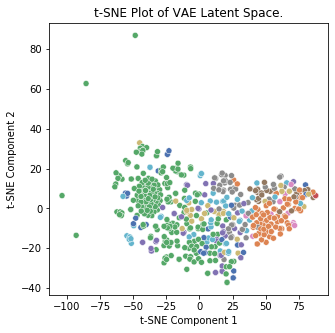

In [14]:
plt.figure(figsize=(5, 5))
plot = sns.scatterplot(x=x, y=y, hue=kmeans_labels["labels"], palette="deep", legend="full")
plot.get_legend().set_visible(False)
plt.title("t-SNE Plot of VAE Latent Space.")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")

# Generate Samples

In [15]:
vectors_with_labels = {
                        0 : {"vecs": {"mu" : [], "var" : []}}, 
                        1 : {"vecs": {"mu" : [], "var" : []}}, 
                        2 : {"vecs": {"mu" : [], "var" : []}}, 
                        3 : {"vecs": {"mu" : [], "var" : []}}, 
                        4 : {"vecs": {"mu" : [], "var" : []}}, 
                        5 : {"vecs": {"mu" : [], "var" : []}},
                        6 : {"vecs": {"mu" : [], "var" : []}}, 
                        7 : {"vecs": {"mu" : [], "var" : []}}, 
                        8 : {"vecs": {"mu" : [], "var" : []}}, 
                        9 : {"vecs": {"mu" : [], "var" : []}},
                        }

prototype_vecs = {}

for index, label in enumerate(kmeans_labels["labels"]):
    
    vectors_with_labels[label]["vecs"]["mu"].append(vectors[0][index])
    vectors_with_labels[label]["vecs"]["var"].append(vectors[1][index])
    

#calculate class-wise mean and variance vectors
for key in vectors_with_labels.keys():
    
    mu_p = np.mean(vectors_with_labels[key]["vecs"]["mu"], axis = 0)
    
    #law of total variance
    avg_var = np.mean(vectors_with_labels[key]["vecs"]["var"], axis = 0)
    inter_mu_var = np.mean([math.dist(mu_p, mu) for mu in vectors_with_labels[key]["vecs"]["mu"]], axis = 0)
    var_p = avg_var + inter_mu_var
    
    prototype_vecs[key] = {"mu_p" : mu_p, "var_p" : var_p}
    
generated_prototype_mean = decoder.predict(np.array([prototype_vecs[i]["mu_p"] for i in prototype_vecs.keys()]))    

print(generated_prototype_mean)

with open("../../data/gen_data/bvae_vecs.pkl", "wb") as f: 
    pickle.dump(generated_prototype_mean, f)


1/1 [==============================] - 0s 62ms/step
[[0.20125872 0.26398402 0.21929733 ... 0.21274257 0.19906299 0.19967017]
 [0.21539402 0.27774122 0.22767344 ... 0.2304067  0.21880066 0.2088282 ]
 [0.18339598 0.25012147 0.20827684 ... 0.19557275 0.1841656  0.1858226 ]
 ...
 [0.2001463  0.26481286 0.21917355 ... 0.21543768 0.2040599  0.19907811]
 [0.20515226 0.26942033 0.22187579 ... 0.2168641  0.20360185 0.20383126]
 [0.19384967 0.25890896 0.21464083 ... 0.20813403 0.19475561 0.19322403]]


In [16]:
#produce a set of samples using prototype mean + prototype variance * N(0,1)
def parameteriser(mu, var):
    return mu + np.exp(0.5 * var) * np.random.normal(0,1)

generated_vecs_p = {}

for key in vectors_with_labels.keys():
    
    num_of_samples = len(vectors_with_labels[key]["vecs"]["mu"])
    class_gen_vecs = []
    
    for i in range(num_of_samples): 
        class_gen_vecs.append(parameteriser(prototype_vecs[key]["mu_p"], prototype_vecs[key]["var_p"]))

    generated_vecs_p[key] = class_gen_vecs


#generate a set of samples, of eqaul size to the current set, based off the class wise prototype mu and var 
generated_samples_p = {}
for key, vecs in generated_vecs_p.items():   
    #[print(vec) for vec in vecs]
    generated_samples_p[key] = [decoder.predict(np.expand_dims(np.array(vec), axis=0)) for vec in vecs]
    
with open("../../data/gen_data/vae_p_gens.pkl", "wb") as f: 
    pickle.dump(generated_samples_p, f)



1/1 [==============================] - 0s 21ms/step


In [17]:

#generate a set of samples based off each indiviual recipes
generated_samples = {
                    0 : [], 
                    1 : [], 
                    2 : [], 
                    3 : [], 
                    4 : [], 
                    5 : [],
                    6 : [], 
                    7 : [], 
                    8 : [], 
                    9 : [],
                    }

for key, vec_dict in vectors_with_labels.items(): 
    for index in range(len(vec_dict["vecs"]["mu"])):
        z = parameteriser(vec_dict["vecs"]["mu"][index], vec_dict["vecs"]["var"][index])
        generated_samples[key].append(decoder.predict(np.expand_dims(z, axis=0)))
    
with open("../../data/gen_data/vae_gens.pkl", "wb") as f: 
    pickle.dump(generated_samples, f)

1/1 [==============================] - 0s 21ms/step
